## TODO: 
- countries that have access to it
- what political factors are affecting which one 
- area where they are 
- russia banned fuel export ban -> what is this doing to our index ? 
- r/oil keep up to date
- G7 price cap what is it 

In [1]:
# Data manipulation and analysis
import numpy as np             # Numerical computing with arrays
import pandas as pd            # Data manipulation and analysis

# Data visualization
import matplotlib.pyplot as plt    # Basic plotting
import seaborn as sns              # Enhanced data visualization
import plotly.express as px        # Interactive visualizations

# Machine learning
import sklearn                   # Machine learning library
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning (if needed)
import tensorflow as tf           # Deep learning framework
import keras                      # High-level neural networks API

# Web scraping
import requests                  # HTTP library for web scraping
from bs4 import BeautifulSoup    # HTML parsing


# Preprocessing and Brent + WTI Analysis

In [2]:
# load in df
df = pd.read_excel("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/PET_PRI_SPT_S1_D.xls", sheet_name=1)
opec_index = pd.read_csv("/Users/visheshnarayan/Downloads/oil_prices_2.csv")

# opec_oil_reserves = pd.read_csv("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/opec_data/T31.xlsx")
# opec_oil_output = pd.read_csv("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/opec_data/T44.xlsx")
# opec_index = pd.read_csv("/Users/visheshnarayan/Documents/Code/UMDClubs/Apex/data/opec_data/T73.xlsx")

In [3]:
opec_index = opec_index.transpose()


In [4]:
# need to fix clean data 
opec_index

,0,1,2,3,4,5,6
ICE Brent,1st forward month,6th forward month,12th forward month,NYMEX WTI,1st forward month,6th forward month,12th forward month
Unnamed: 1,96.91,97.27,97.52,NaN,89.58,94.39,95.63
Unnamed: 2,104.03,104.63,104.74,NaN,89.74,97.6,99.39
Unnamed: 3,114.67,113.73,112.19,NaN,102.98,105.32,104.83
Unnamed: 4,123.09,121.19,118.92,NaN,110.04,111.46,110.51
...,...,...,...,...,...,...,...
Unnamed: 283,78.55,70.11,NaN,NaN,NaN,NaN,NaN
Unnamed: 284,83.44,78.77,NaN,NaN,NaN,NaN,NaN
Unnamed: 285,75.58,70.69,NaN,NaN,NaN,NaN,NaN
Unnamed: 286,75.49,69.62,NaN,NaN,NaN,NaN,NaN


In [5]:
# drop first two rows with uneccessary data
df = df.drop(df.index[:2], axis=0)
df.columns = ["time", "wti", "brent"]

# use time series as index
df = df.set_index("time")

In [6]:
# drop nan
df = df.dropna(axis=0)
df

,wti,brent
time,,
1987-05-20,19.75,18.63
1987-05-21,19.95,18.45
1987-05-22,19.68,18.55
1987-05-26,19.35,18.63
1987-05-27,19.38,18.6
...,...,...
2023-09-12,88.87,93.58
2023-09-13,88.59,93.04
2023-09-14,90.13,95.2


### Observations:
1. Brent has on average lower net return but more deviation: higher deviation could mean better response to economic factors 
2. Brent has lowest min -3%
3. All other features are relatively the same 

In [7]:
df["brent_return"] = df["brent"].pct_change()
df["wti_return"] = df["wti"].pct_change()

print(df["brent_return"].describe())
print(df["wti_return"].describe())

count    9066.000000
mean        0.000504
std         0.025286
min        -0.474654
25%        -0.011217
50%         0.000589
75%         0.012334
max         0.509868
Name: brent_return, dtype: float64
count    9066.000000
mean        0.000136
std         0.043586
min        -3.019661
25%        -0.012003
50%         0.000728
75%         0.013222
max         0.530864
Name: wti_return, dtype: float64


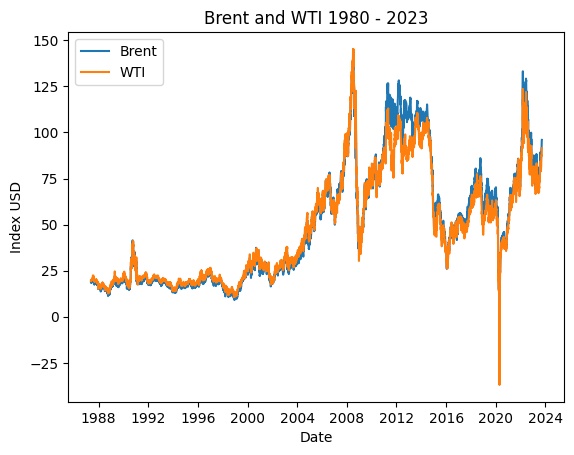

In [81]:
# closely follow each other, brent is higher during 2009 - 2015 period
# on average brent has lower lows during dip in indexes 

plt.title("Brent and WTI 1980 - 2023")
plt.xlabel("Date")
plt.ylabel("Index USD")
plt.plot(df.index, df["brent"], label="Brent")
plt.plot(df.index, df["wti"], label="WTI")
plt.legend()
plt.show()

In [82]:
corr = df["brent_return"].corr(df["wti_return"])
print(f"Correlation between Brent and WTI returns: {corr}")

Correlation between Brent and WTI returns: 0.4688147236990702


# Player Trading Windows and Index Fluctuations
__Observations__: 
1. Neymar, from Barcelona to PSG, is traded on the 3rd, and oil prices immediately spike in Brent index and slowly rise in WTI

Possible hypothesis: 
--> Brent is more responsive to player trades

## 2017 August - Neymar + Mbappe

__Notes:__
1. Both indexes have immediate jump in end of july and rise until trading date
2. Since both Neymar and Mbappe were being traded, could be possible why prices stayed high throughout August
3. Strictly looking at 4 day window described in paper, WTI responded better showing spike while Brent stayed the trading window
4. WTI responds better during Mbappe having steady increase whereas Brent stays again stable or fluctuating back and forth

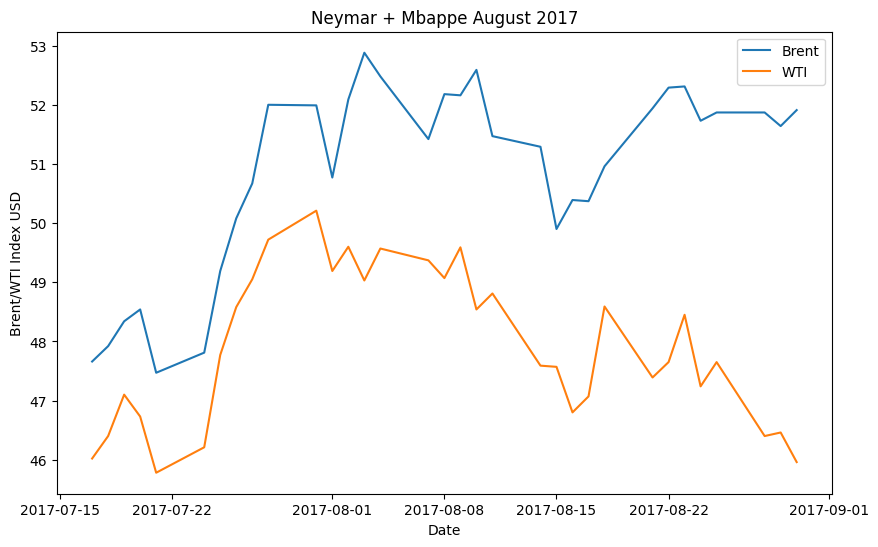

In [86]:
# examine month of when players are being traded
# given windows; august 2017, neymar + mbappe
# start in mid july to see index changes prior to trading window
neymar = df.loc["2017-07-15":"2017-08-30"]
plt.figure(figsize=(10,6))
plt.title("Neymar + Mbappe August 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar.index, neymar["brent"], label="Brent")
plt.plot(neymar.index, neymar["wti"], label="WTI")
plt.legend()

### Neymar 4 day window
1. __Brent__ stayed stable whereas __WTI__ shows spike in index especially on the 3rd (day of trade)
2. __Brent__ stays relatively stable but __WTI__ starts climbing again around expected Mbappe trade window
3. __WTI__ indicates responds to trading period faster than __Brent__

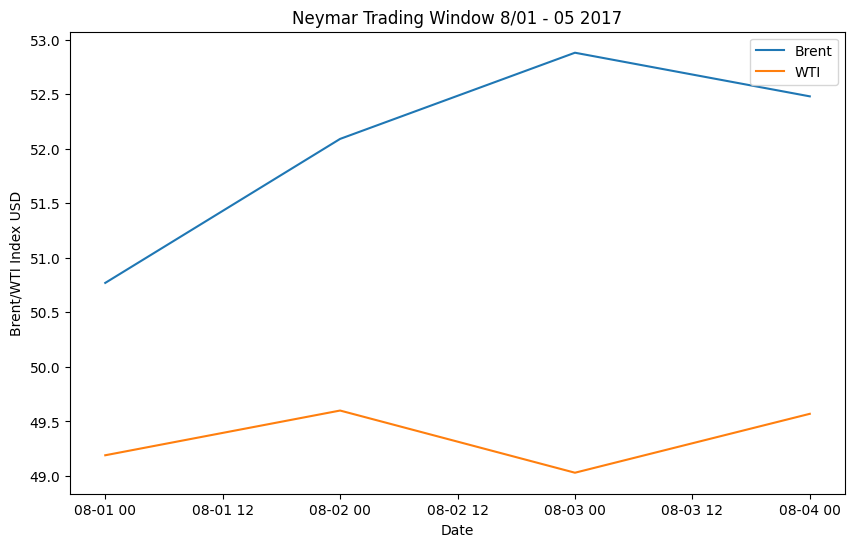

In [87]:
# "4 day window" -> August 1 to August 5
neymar_4_day = df.loc["2017-08-01":"2017-08-05"]
plt.figure(figsize=(10,6))
plt.title("Neymar Trading Window 8/01 - 05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_4_day.index, neymar_4_day["brent"], label="Brent")
plt.plot(neymar_4_day.index, neymar_4_day["wti"], label="WTI")
plt.legend()

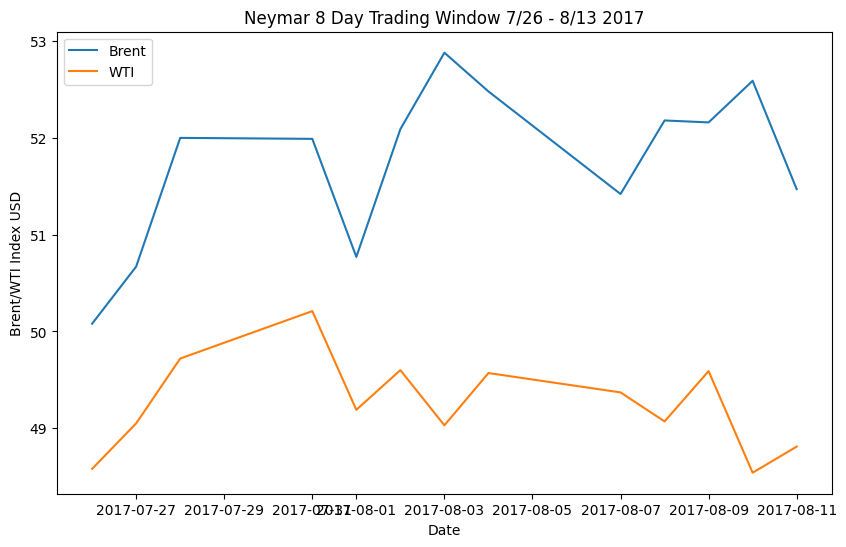

In [92]:
# verify by creating larger window
# indications of oil supply squeeze -> notice spike in Brent @8/2 - 3
neymar_8_day = df.loc["2017-07-26":"2017-08-13"]
plt.figure(figsize=(10,6))
plt.title("Neymar 8 Day Trading Window 7/26 - 8/13 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(neymar_8_day.index, neymar_8_day["brent"], label="Brent")
plt.plot(neymar_8_day.index, neymar_8_day["wti"], label="WTI")
plt.legend()

### Mbappé 4 day window


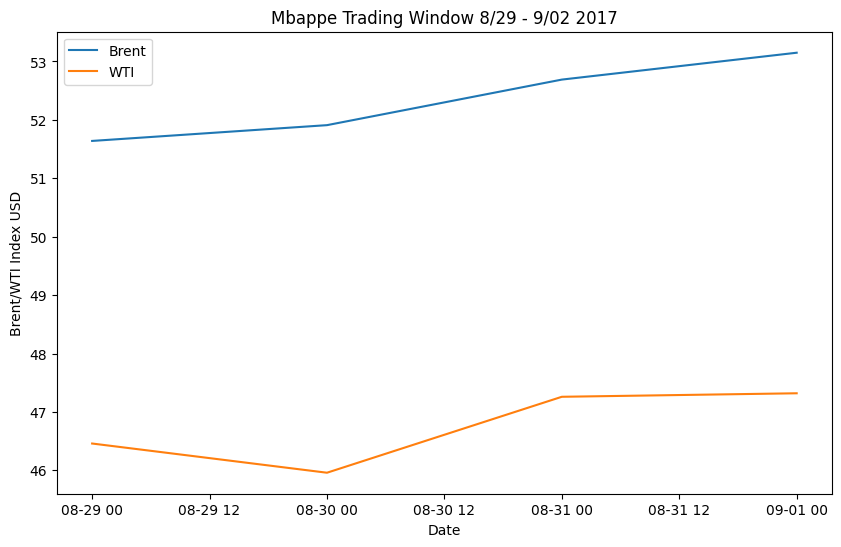

In [93]:
# "4 day window" -> August 29 to September 2
mbappe_4_day = df.loc["2017-08-29":"2017-09-02"]
plt.figure(figsize=(10,6))
plt.title("Mbappe Trading Window 8/29 - 9/02 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_4_day.index, mbappe_4_day["brent"], label="Brent")
plt.plot(mbappe_4_day.index, mbappe_4_day["wti"], label="WTI")
plt.legend()

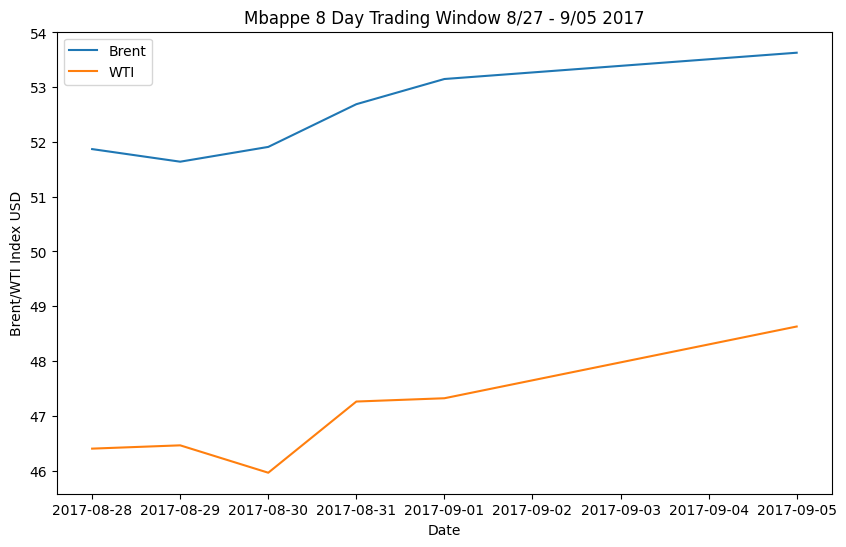

In [95]:
# not much revealed, create larger window 4 days both ways (8 days)
# WTI responds faster, in this case Brent has dip during expected squeeze day but WTI starts rising
mbappe_8_day = df.loc["2017-08-27":"2017-09-05"]
plt.figure(figsize=(10,6))
plt.title("Mbappe 8 Day Trading Window 8/27 - 9/05 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(mbappe_8_day.index, mbappe_8_day["brent"], label="Brent")
plt.plot(mbappe_8_day.index, mbappe_8_day["wti"], label="WTI")
plt.legend()

### Lukaku
__Note__: In Lukaku's case, Brent responded faster and has steeper incline indicating supply squeeze

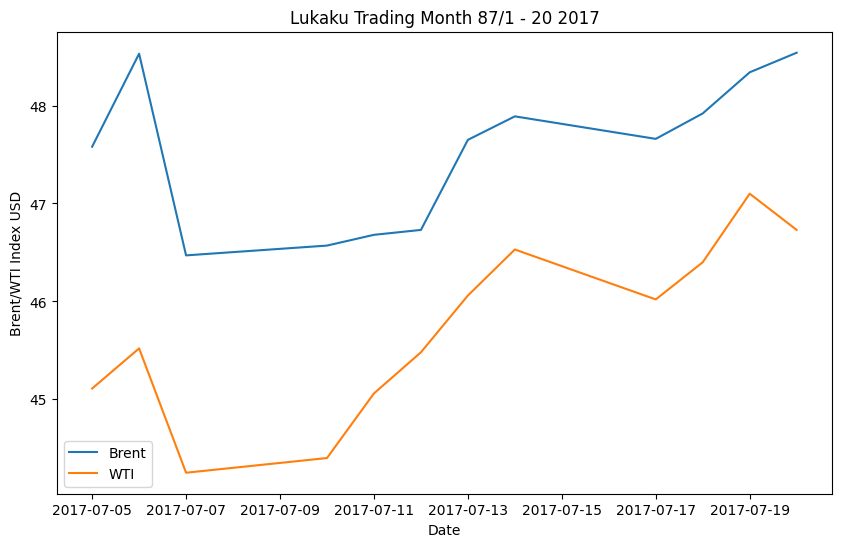

In [96]:
lukaku = df.loc["2017-07-01":"2017-07-20"]
plt.figure(figsize=(10,6))
plt.title("Lukaku Trading Month 87/1 - 20 2017")
plt.xlabel("Date")
plt.ylabel("Brent/WTI Index USD")
plt.plot(lukaku.index, lukaku["brent"], label="Brent")
plt.plot(lukaku.index, lukaku["wti"], label="WTI")
plt.legend()

## Data Analysis

In [54]:
import yfinance as yf
sp500 = yf.download("^GSPC", df.index[0], df.index[-1]) # ^GSPC ticker for SP500
dji = yf.download("^DJI", df.index[0], df.index[-1]) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [55]:
df["dji"] = dji["Close"]
df["sp500"] = sp500["Close"]
df = df.dropna()
df

,wti,brent,brent_return,wti_return,dji,sp500
time,,,,,,
1992-01-02,19.43,18.45,0.039437,0.014621,3172.399902,417.260010
1992-01-03,19.22,18.5,0.002710,-0.010808,3201.500000,419.339996
1992-01-06,19.24,18.75,0.013514,0.001041,3200.100098,417.959991
1992-01-07,18.72,18.4,-0.018667,-0.027027,3204.800049,417.399994
1992-01-08,17.95,17.3,-0.059783,-0.041132,3203.899902,418.100006
...,...,...,...,...,...,...
2023-09-11,87.3,91.97,0.001306,-0.002400,34663.718750,4487.459961
2023-09-12,88.87,93.58,0.017506,0.017984,34645.988281,4461.899902
2023-09-13,88.59,93.04,-0.005770,-0.003151,34575.531250,4467.439941


In [57]:
corr

,brent_return,wti_return,dji,sp500
brent_return,1.000000,0.457602,0.009999,0.011554
wti_return,0.457602,1.000000,-0.005352,-0.004596
dji,0.009999,-0.005352,1.000000,0.993576
sp500,0.011554,-0.004596,0.993576,1.000000


/var/folders/p6/9c98fqb51038xhz870chsj280000gn/T/ipykernel_6096/3459143166.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

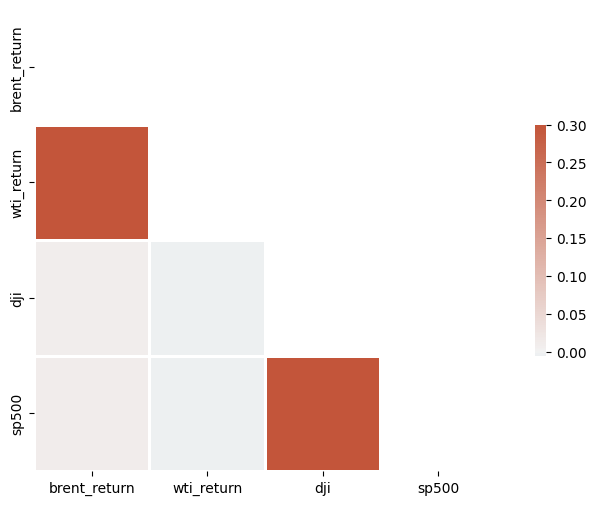

In [56]:
# use correlation matrix to indicate independence of vars
corr = df.corr()

# dont want to see repeating correlation values in upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .5})
